In [ ]:
# Prerequisites
# One of the most key metrics is the number of orders. Let's see how change of order form on site
# will increase conversion rate.
# We add price before sale and after to form. Our key metric that we want to monitor is order form submit.
# In A/B tests, we split users into two random groups: control and treatment.
# For users in the control group, we will show current version of form and for users in the treatment group,
# we will deploy the new form order.
# Before run test let's formulating null and alternative hypotheses. H0: nothing will change, HA: we get statistical
# significant changes
# H0:Conversion Rate control = Conversion Rate treatment
# HA:Conversion Rate control != Conversion Rate treatment

In [1]:
# Steps:
# 1. Determine the sample size
# 1.1. Find distribution type
# 1.2. Find deviations in the AA test
# 1.3. Expected conversion growth
# 2. Generate data
# 3. Run tests

In [2]:
# Import Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import statsmodels.stats.api as sms
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

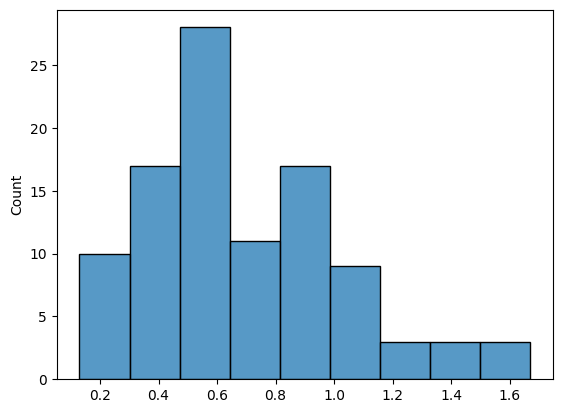

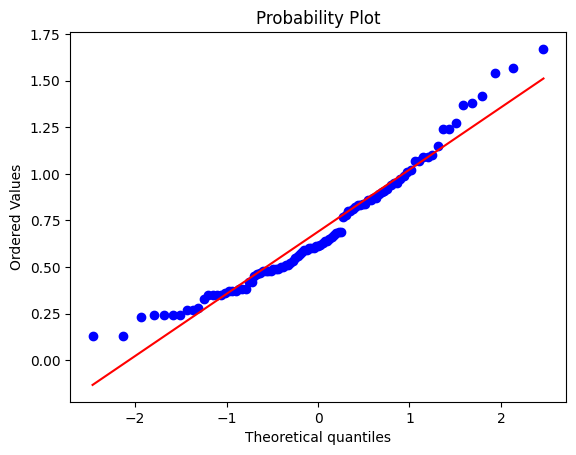

In [3]:
# 1. Determine the sample size
# 1.1. Distribution type
# Take CR from 100 random samples
conversion_rate_100 = [0.97, 0.78, 0.38, 0.48, 0.83, 0.69, 0.49, 0.49, 1.07, 0.50, 0.48, 0.83, 0.24, 0.35, 0.60, 0.65,
                       0.60, 0.49, 0.42, 0.53, 0.64, 0.45, 0.59, 0.27, 1.37, 0.80, 0.56, 0.84, 0.38, 0.99, 1.02, 0.68,
                       0.13, 0.87, 0.38, 0.62, 0.95, 0.37, 0.90, 0.92, 1.01, 0.46, 0.37, 0.95, 0.82, 0.86, 1.09, 0.57,
                       0.81, 1.54, 0.13, 1.09, 1.24, 0.77, 1.07, 0.59, 0.48, 0.47, 1.67, 0.67, 0.61, 0.23, 0.66, 0.51,
                       0.48, 0.60, 0.35, 0.50, 0.52, 0.36, 0.37, 0.27, 1.38, 1.24, 0.89, 0.58, 0.87, 0.28, 0.80, 0.24,
                       0.84, 1.42, 0.24, 0.35, 0.63, 0.33, 0.55, 0.91, 1.27, 0.61, 1.57, 0.42, 0.35, 0.51, 1.10, 1.15,
                       0.24, 0.94, 0.64, 0.86, 0.69]
# Plot a histogram
sns.histplot(conversion_rate_100)
plt.show()
# QQ plot, check the distribution for normality
stats.probplot(conversion_rate_100, dist="norm", plot=plt)
plt.show()

In [4]:
# Conclusion: We got the binomial distribution, we can say that it is close to normal.

In [5]:
# 1.2. Deviations in the AA test
# Find the standard deviation.
st_dev = np.std(conversion_rate_100) / 100
print('st_dev:', st_dev)

# Check that the generated samples have the similar standard deviation
control_sample_cr = 0.007
control_sample_size = 66667
st_dev_gen = []

for _ in range(1000):
    control_sample_means_gen = np.random.normal(control_sample_cr, st_dev, 10000)
    st_dev_gen += [np.std(control_sample_means_gen)]

print('st_dev_gen:', np.mean(st_dev_gen))

st_dev: 0.0033438952037721536
st_dev_gen: 0.003343243551734564


In [6]:
# Conclusion: in the generated samples, the resulting value of the standard deviation
# deviates very slightly from actual.

In [7]:
# Generate two groups of samples with similar input parameters. We get the P-value using the Student's test.
# If the probability is less than 5%, increase the number in the counter.
# Next, we divide the sum in the counter by the count of iterations.
# So we get the probability of rejecting the correct null hypothesis.
p_value = []
cnt = 0
iteration = 1000
for _ in range(iteration):
    normal_dist_1 = np.random.normal(control_sample_cr, st_dev, 10000).tolist()
    normal_dist_2 = np.random.normal(control_sample_cr, st_dev, 10000).tolist()
    result = ttest_ind(normal_dist_1, normal_dist_2)
    p_value.append(result.pvalue)
    if result.pvalue <= 0.05:
        cnt += 1
print('AA test probability:', cnt / iteration)

AA test probability: 0.055


In [8]:
# 1.3. Expected conversion growth
# As a result of changing the shape, we want to increase the conversion by 0.15 percentage points.
# Calculate the required sample size for the AB test. Probability of rejecting a true null hypothesis alpha = 0.05,
# probability of accepting an incorrect null hypothesis power = 0.8
uplift = 0.0015
es = sms.proportion_effectsize(control_sample_cr, control_sample_cr + uplift)
number_of_observations = sms.NormalIndPower().solve_power(es, power=0.8, alpha=0.05, ratio=1)
print('number_of_observations per sample (alpha=0.05, power=0.8):', round(number_of_observations))
# Conclusion: With current attendance, it will take almost 2 months.
# Reduce criteria to alpha = 0.10, power = 0.70
number_of_observations = sms.NormalIndPower().solve_power(es, power=0.7, alpha=0.1, ratio=1)
print('number_of_observations per sample (alpha = 0.10, power = 0.70):', round(number_of_observations))

number_of_observations per sample (alpha=0.05, power=0.8): 53526
number_of_observations per sample (alpha = 0.10, power = 0.70): 32085


In [9]:
# Conclusion: now ok, less than a month

In [10]:
# Alternative method
users = control_sample_size
basic_conversion_rate = control_sample_cr
margin_of_error = 1.96 * ((basic_conversion_rate * (1 - basic_conversion_rate)) / users) ** 0.5
lower_value = (basic_conversion_rate - margin_of_error)
upper_value = (basic_conversion_rate + margin_of_error)
print('margin_of_error:', margin_of_error, 'lover_value:', lower_value, 'upper_value:', upper_value)
print(lower_value / basic_conversion_rate * 100)
# Example data
acceptable_margin_of_error = 0.0015
minimum_detectable_effect = acceptable_margin_of_error
sample_size = basic_conversion_rate * (1 - basic_conversion_rate) * (1.96 / acceptable_margin_of_error) ** 2
# Formula considering power
sample_size_power = 16 * basic_conversion_rate * (1 - basic_conversion_rate) / minimum_detectable_effect ** 2
print('sample_size:', round(sample_size))
print('sample_size (power):', round(sample_size_power))

margin_of_error: 0.0006328842084361827 lover_value: 0.0063671157915638175 upper_value: 0.007632884208436183
90.95879702234025
sample_size: 11868
sample_size (power): 49429


In [11]:
# 2. Generate data
control_sample_cr = 0.0063
control_sample_size = 30313
control_sample_orders = control_sample_size * control_sample_cr
treatment_sample_cr = 0.0077
treatment_sample_size = 30483
treatment_sample_orders = treatment_sample_size * treatment_sample_cr
print(control_sample_orders)
print(treatment_sample_orders)

190.9719
234.7191


In [12]:
# 3. Run tests
# proportions_ztest (group A count of orders, group B count of orders, group A users, group B users)
p_value_z = proportions_ztest([control_sample_orders, treatment_sample_orders],
                              [control_sample_size, treatment_sample_size])
print('p_value_z:', p_value_z[1])


p_value_z: 0.03846146284670743


In [13]:
# Conclusion: p-value = 3.8%. Hypothetically, we can reject H0 and conclude that there is a difference in conversion,
# but given the fact that we have significantly reduced the alpha and power tolerance levels,
# we got an extremely marginal value. We accept H0, changing the form did not give an increase in conversion.